# Introduction

Here we want to replicate Sorscher et al.'s (2023) results of Grid cells arising from a path-integrating RNN which predicts place cell outputs.

The model takes velocity inputs and predicts place cell output (velocity to place cell)
 - note that in order to encourage path integration within the RNN, hidden activity of the RNN is set by an encoder from place cell activations but only for the first step in each trajectory.

In [6]:
## setup ##
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt

# local imports #
from experiment.code.GridModels.code.models import vel2pc_RNN as v2p

## Training a model

In [7]:

# introduce a model #
reload(v2p)
print(v2p.options.__dict__)
model, dataset, losses = v2p.get_model_and_data(v2p.options) #will try to load a model if it exists, otherwise will train a new one

Using device: cuda
{'device': device(type='cuda'), 'save_dir': '../code/GridModels/data/sorscher_models/', 'n_steps': 100000, 'batch_size': 32, 'sequence_length': 20, 'n_epochs': 101, 'train_ratio': 0.8, 'environment_scale': 1.5, 'framerate': 0.016666666666666666, 'learning_rate': 0.0003, 'Ng': 1024, 'Np': 512, 'place_cell_rf': 0.15, 'pc_type': 'diff_of_gaussians', 'RNN_type': 'RNN', 'activation': 'relu', 'optimizer': 'adam', 'sparsity': 0.0}
Loading existing model and data!


/tmp/ipykernel_2773747/3808910818.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i].set(title = title, yscale = 'log',xscale='log')


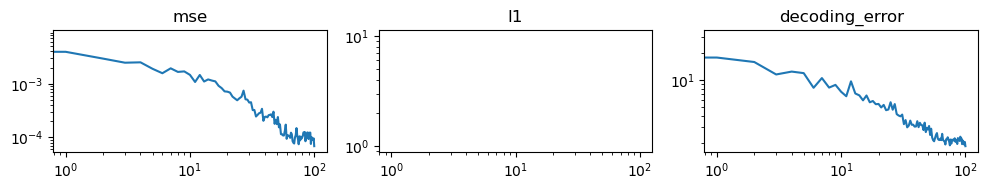

In [8]:
# plot losses - ideally they should all have reached a plateu

fig, ax = plt.subplots(1,3, figsize = (10,2))
for i, title in enumerate(['mse','l1','decoding_error']):
    ax[i].plot(np.array(losses['validation'][title], dtype=np.float32))
    ax[i].set(title = title, yscale = 'log',xscale='log')
fig.tight_layout()

## Ratemaps and grid scoring

In [9]:
# generate new trajectory and get hidden activity
pc_nav_rates_df, hidden_activity_df, predicted_pc_df = v2p.generate_hidden_activity(model,v2p.options)

generating trajectory


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:16<00:00, 732.99it/s]


generating hidden activity


100%|██████████| 100000/100000 [01:15<00:00, 1320.26it/s]


Using device: cuda


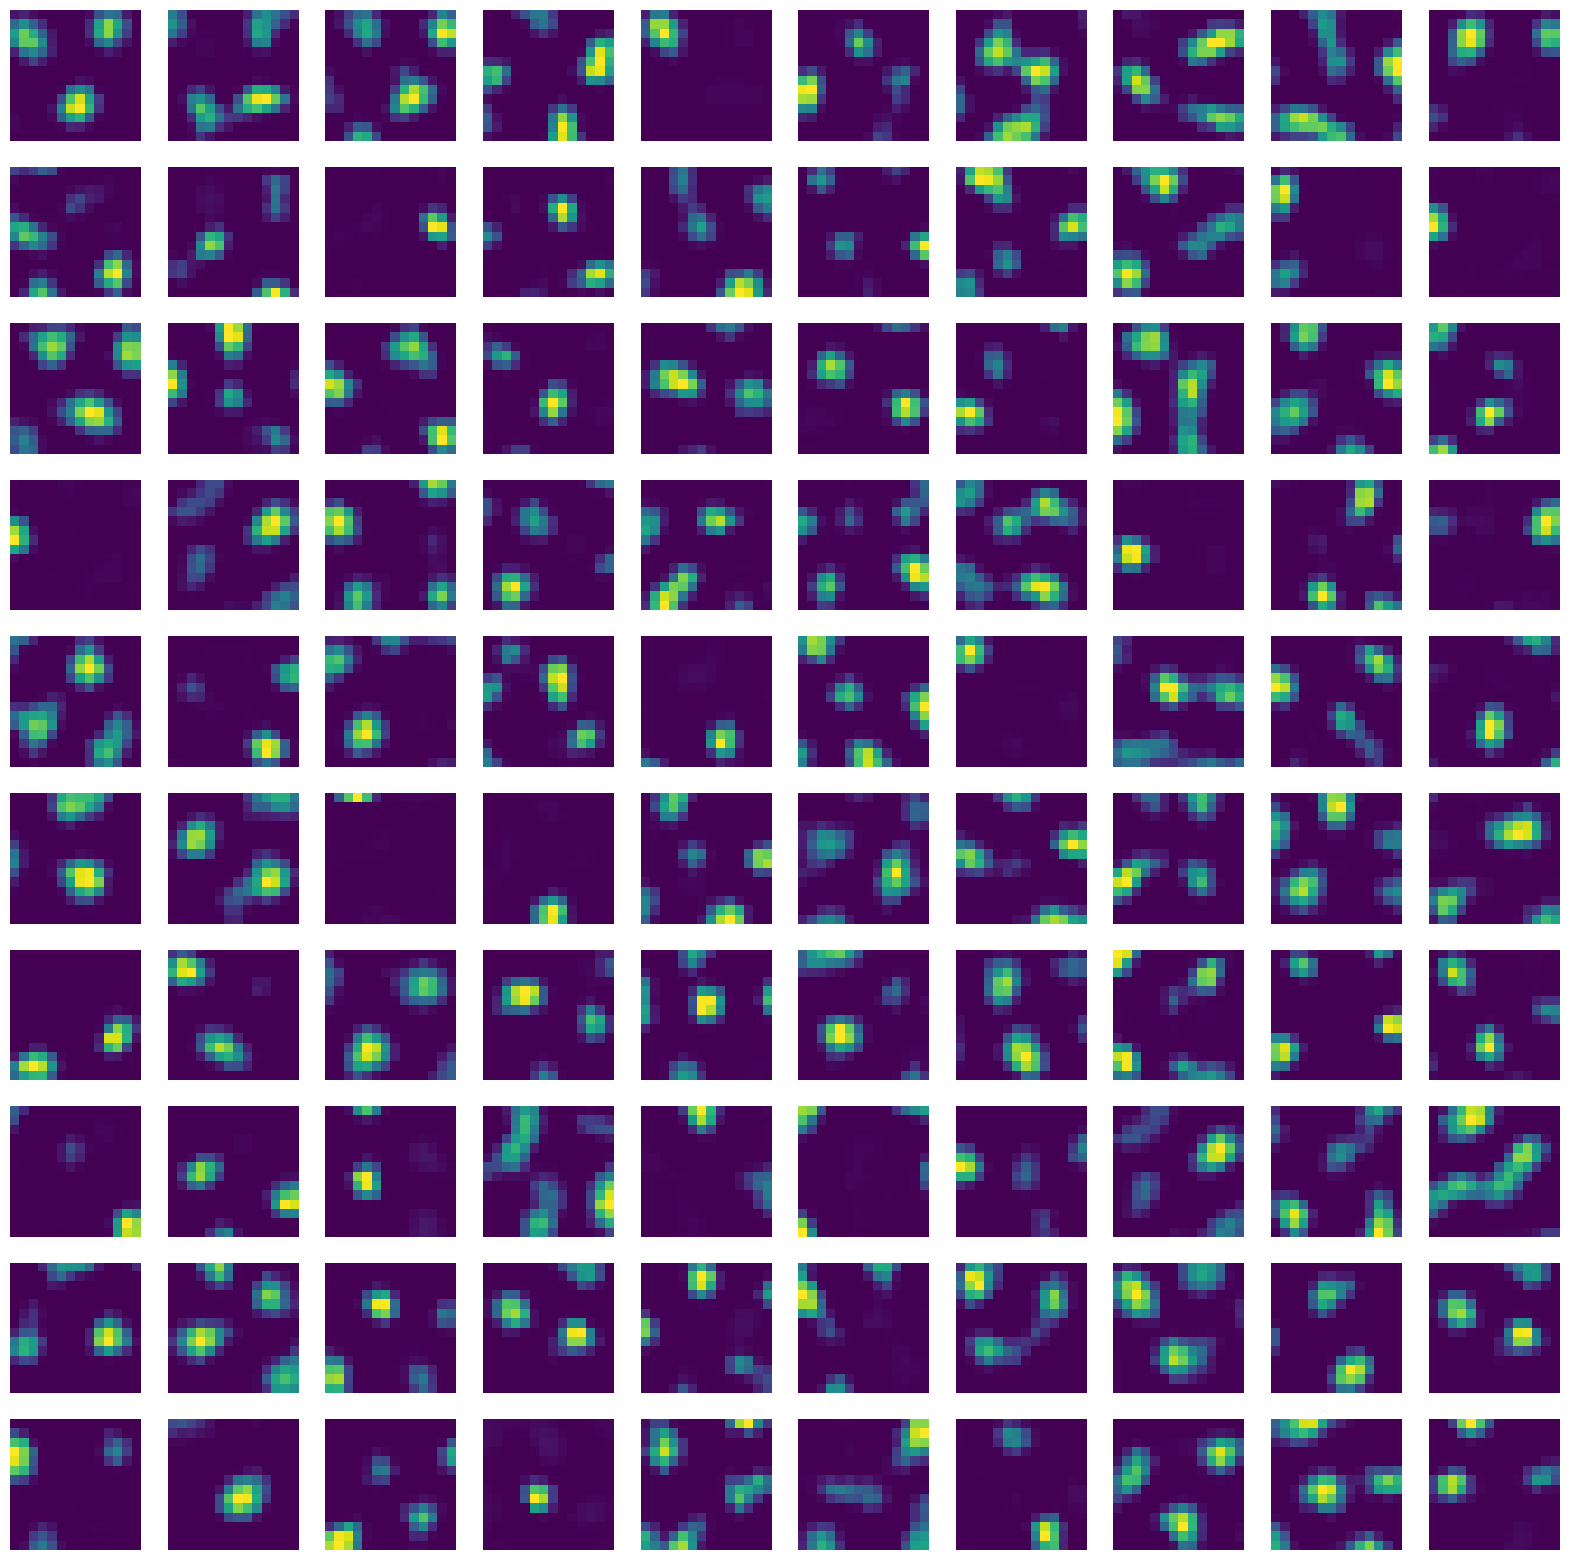

In [10]:
#plot hidden activity
from GridMaze.analysis.cluster_tuning import spatial

rates = hidden_activity_df.firingrate.values
rates[rates<0] = 0 #rectified linear activations
positions = pc_nav_rates_df.centroid_position.values
ratemaps, binx, biny = spatial.get_2D_ratemaps(rates,positions,
                                               x_size = 0.10,
                                               y_size = 0.10,
                                               smooth_SD = 0.0)

# let's plot a 10x10 panel of 100 random neurons
rng = np.random.default_rng(42)  # Use any integer you like
random_integers = rng.integers(0, v2p.options.Ng+1, size=100) 
fig, ax = plt.subplots(10,10, figsize = (20,20))
for i, each_unit in enumerate(random_integers):
    ax.flatten()[i].imshow(ratemaps[each_unit],origin='lower')
    ax.flatten()[i].axis('off')

In [11]:
position_df = pc_nav_rates_df[[x for x in pc_nav_rates_df.columns if 'centroid_position' in x ]]
nav_rates_df = position_df.join(hidden_activity_df)

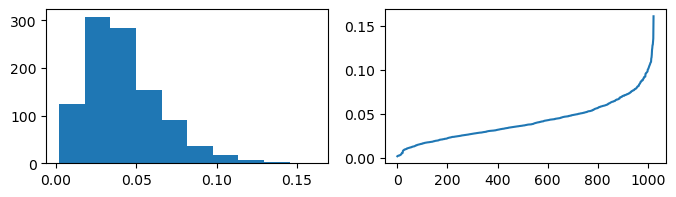

In [12]:
# We see many units with very sparse ratemaps, likely with low firing.
# let's filter those away:

unit_means = hidden_activity_df.mean(axis=0).values #mean activity per unit
neurons_by_activity = np.argsort(unit_means)
sorted_activity = unit_means[neurons_by_activity]
fig, ax = plt.subplots(1,2, figsize =(8,2))
ax[0].hist(unit_means)
ax[1].plot(sorted_activity)

computing spatial autocorrelograms per ratemap


100%|██████████| 1024/1024 [00:05<00:00, 179.36it/s]
/nfs/nhome/live/cburns/.conda/envs/GridMaze/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performing and plotting umap!


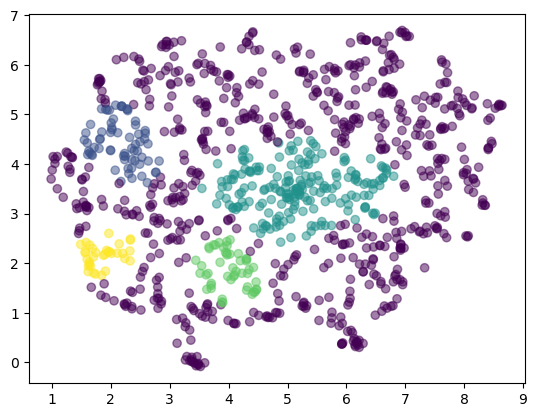

In [17]:
# now we can look for grid cell models using the UMAP method:
# here we follow an efficient population-level model, relying on clustering of periodicity in ratemaps.
from experiment.code.GridModels.code.measures import gridcell_metrics as gcm

#coding from scratch here:
from tqdm import tqdm
from GridMaze.analysis.cluster_tuning import spatial
#for Gardner 2022 grid cell classification
import umap
from sklearn.cluster import DBSCAN

##continuing after we get all our ratemaps
print('computing spatial autocorrelograms per ratemap')
unit_IDs = hidden_activity_df.firingrate.columns  # this will be columns
vector_list = []

#filter before umap 
valid_indices = [x[0] for x in np.argwhere((hidden_activity_df.mean(axis=0)>0.0).values)]
valid_columns = hidden_activity_df.columns[valid_indices]
filtered_df = hidden_activity_df[valid_columns]

valid_ratemaps = ratemaps[valid_indices]
grid_scores = []
sacs = []
for ratemap in tqdm(valid_ratemaps):
    coords_range = [[min(binx),max(binx)],[min(biny),max(biny)]]
    sac = spatial.autoCorr2D(np.nan_to_num(ratemap.copy(), 0), ~np.isfinite(ratemap.copy()))
    mask_parameters = [(0.3,1)] #trying to exclude the centre as in Gardner et al.
    scorer = gcm.GridScorer(len(binx)-1, coords_range, mask_parameters)
    gridscore = scorer.get_grid_properties(ratemap)['gridscore_60']
    mask = scorer._get_ring_mask(mask_parameters[0][0],mask_parameters[0][1])
    vectorised = sac.flatten()[mask.flatten()==1] # exclude outside disc and vectorise
    z_scored =  (vectorised - vectorised.mean())/vectorised.std()
    if np.isnan(gridscore):
        continue
    sacs.append(sac)
    grid_scores.append(gridscore)
    vector_list.append(vectorised)
    
sac_df = pd.DataFrame(dict(zip(unit_IDs, vector_list)))

print('Performing and plotting umap!')
umap_df = sac_df.T # we need unit_IDs as index, z-scored vectors as rows
reducer = umap.UMAP(random_state = 42, n_neighbors = 5, min_dist = 0.05, metric ='manhattan') #params from Gardner et al. 2022
data_umap = reducer.fit_transform(umap_df)
dbscan = DBSCAN(eps=0.5,min_samples = 30) #adjust 'eps' might be needed
labels = dbscan.fit_predict(data_umap)
plt.scatter(data_umap[:,0], data_umap[:,1], c=labels, alpha=0.5)
plt.show()


(array([ 76., 185., 237., 171., 125., 104.,  65.,  35.,  19.,   7.]),
 array([-0.40190217, -0.25171066, -0.10151915,  0.04867236,  0.19886387,
         0.34905538,  0.49924689,  0.6494384 ,  0.79962991,  0.94982142,
         1.10001293]),
 <BarContainer object of 10 artists>)

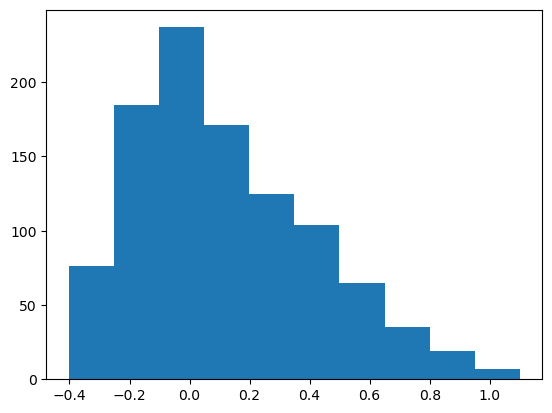

In [18]:
plt.hist(grid_scores)

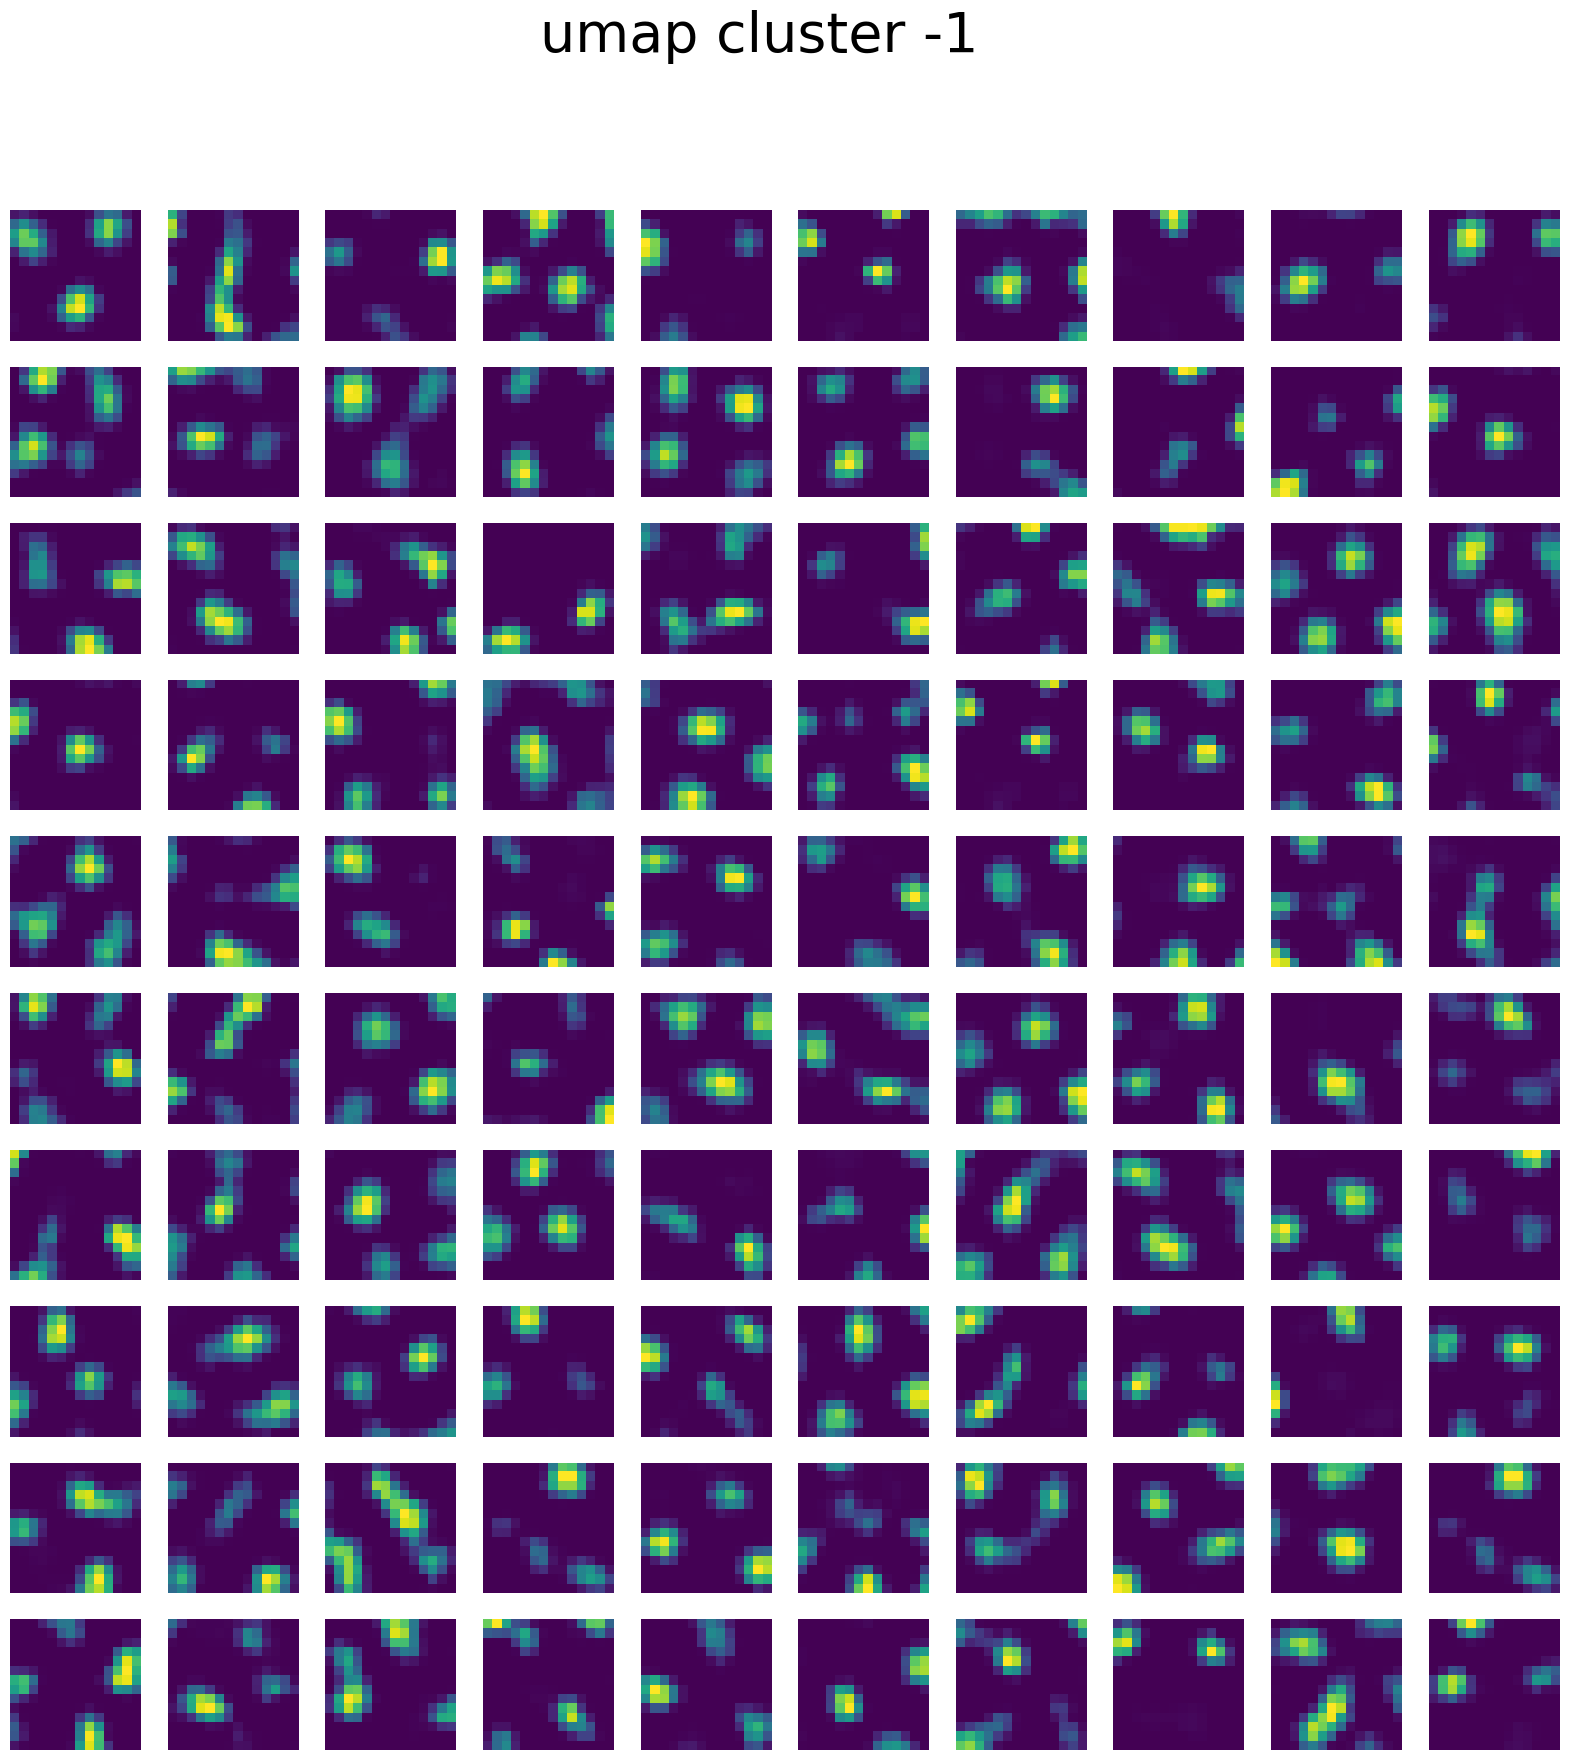

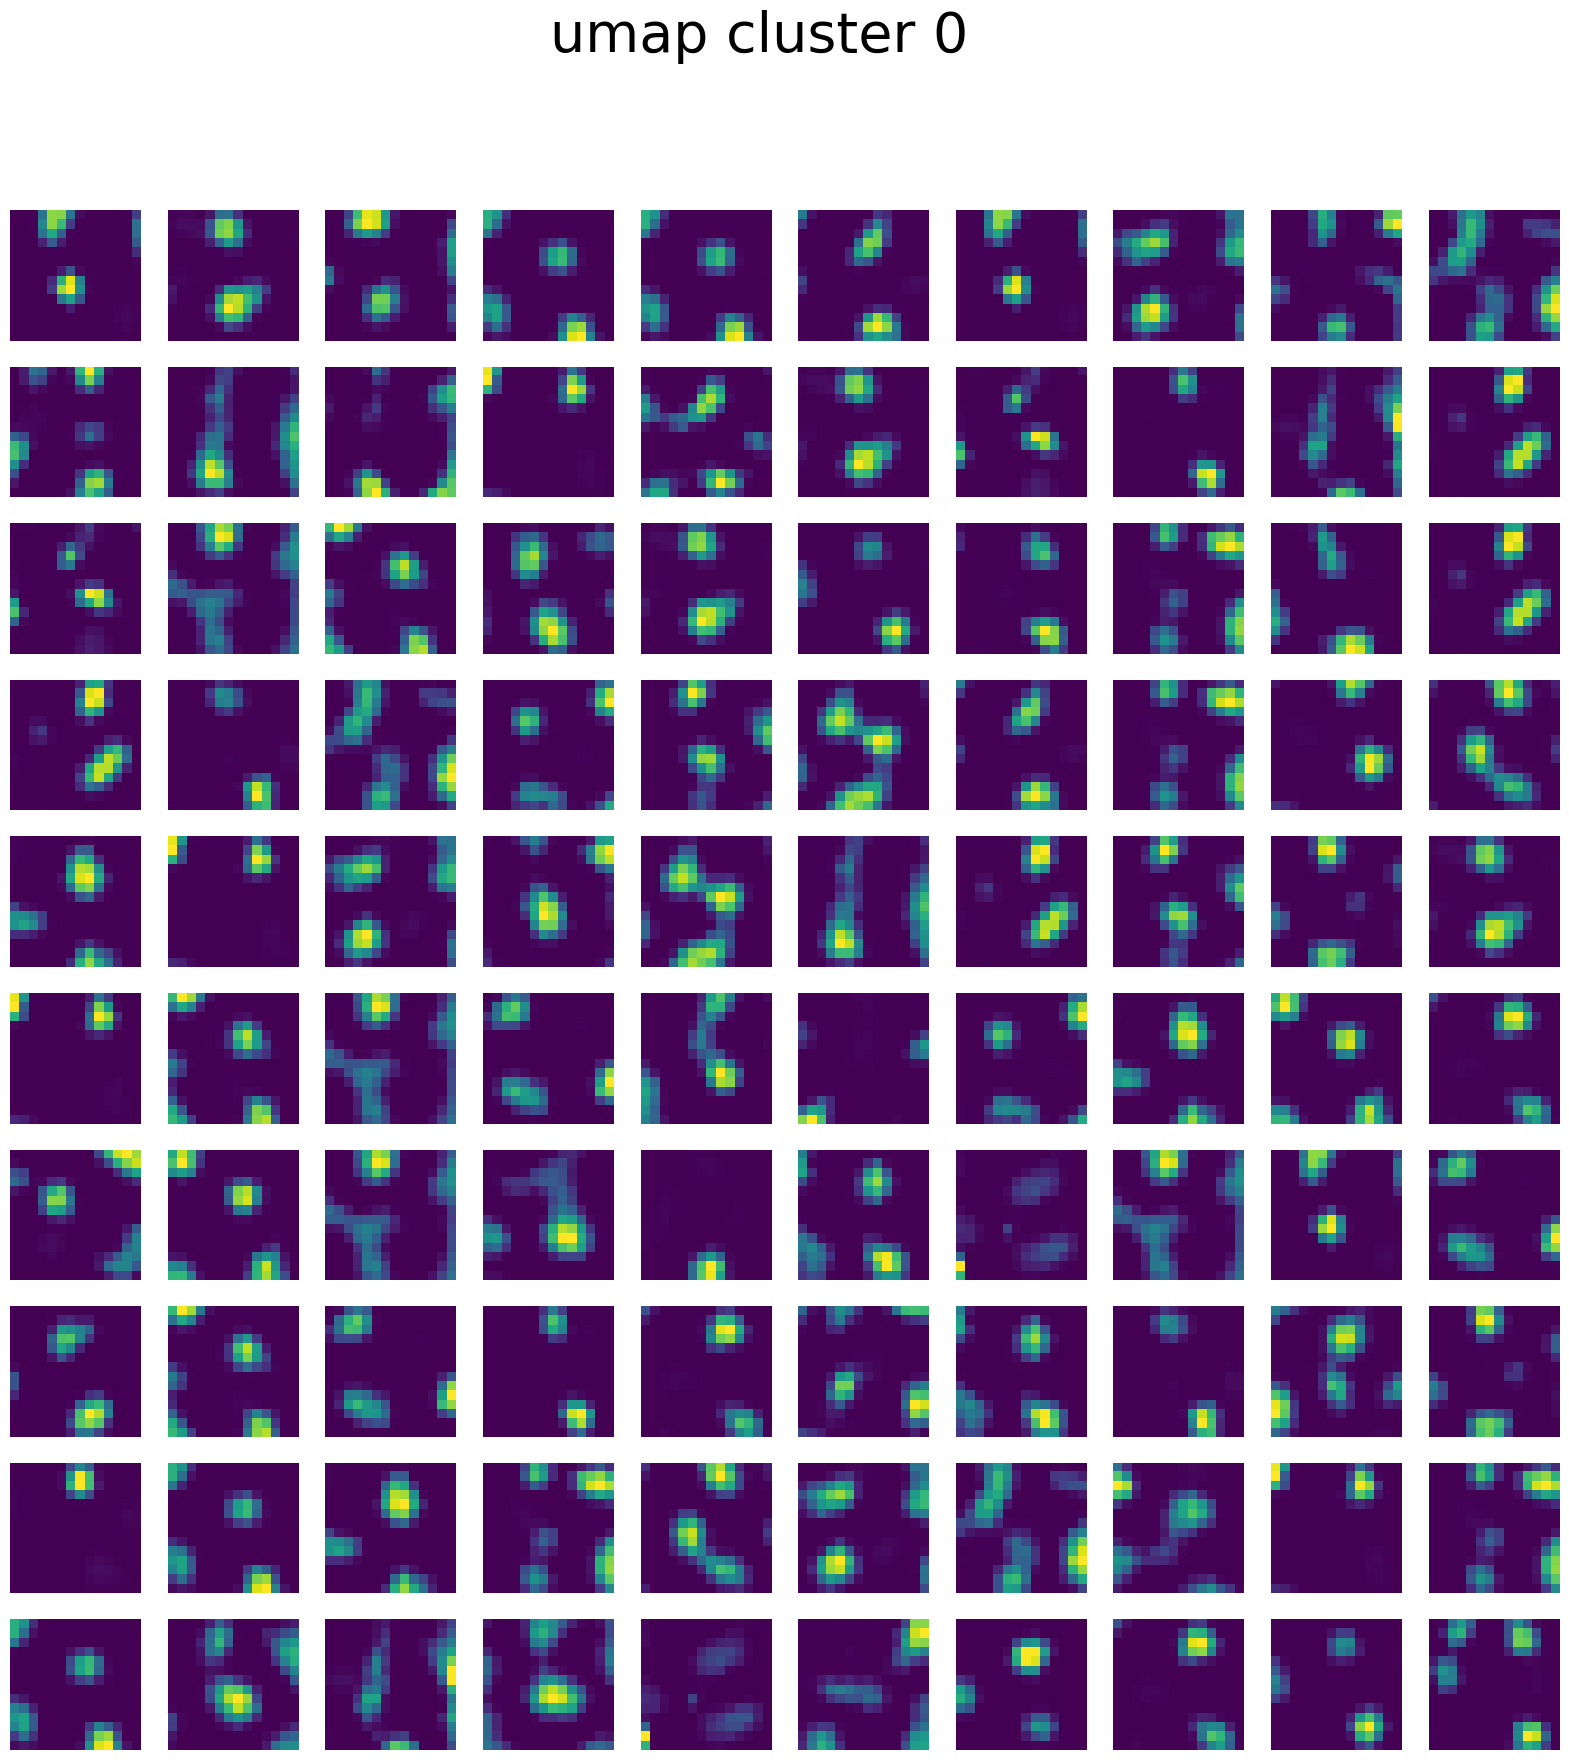

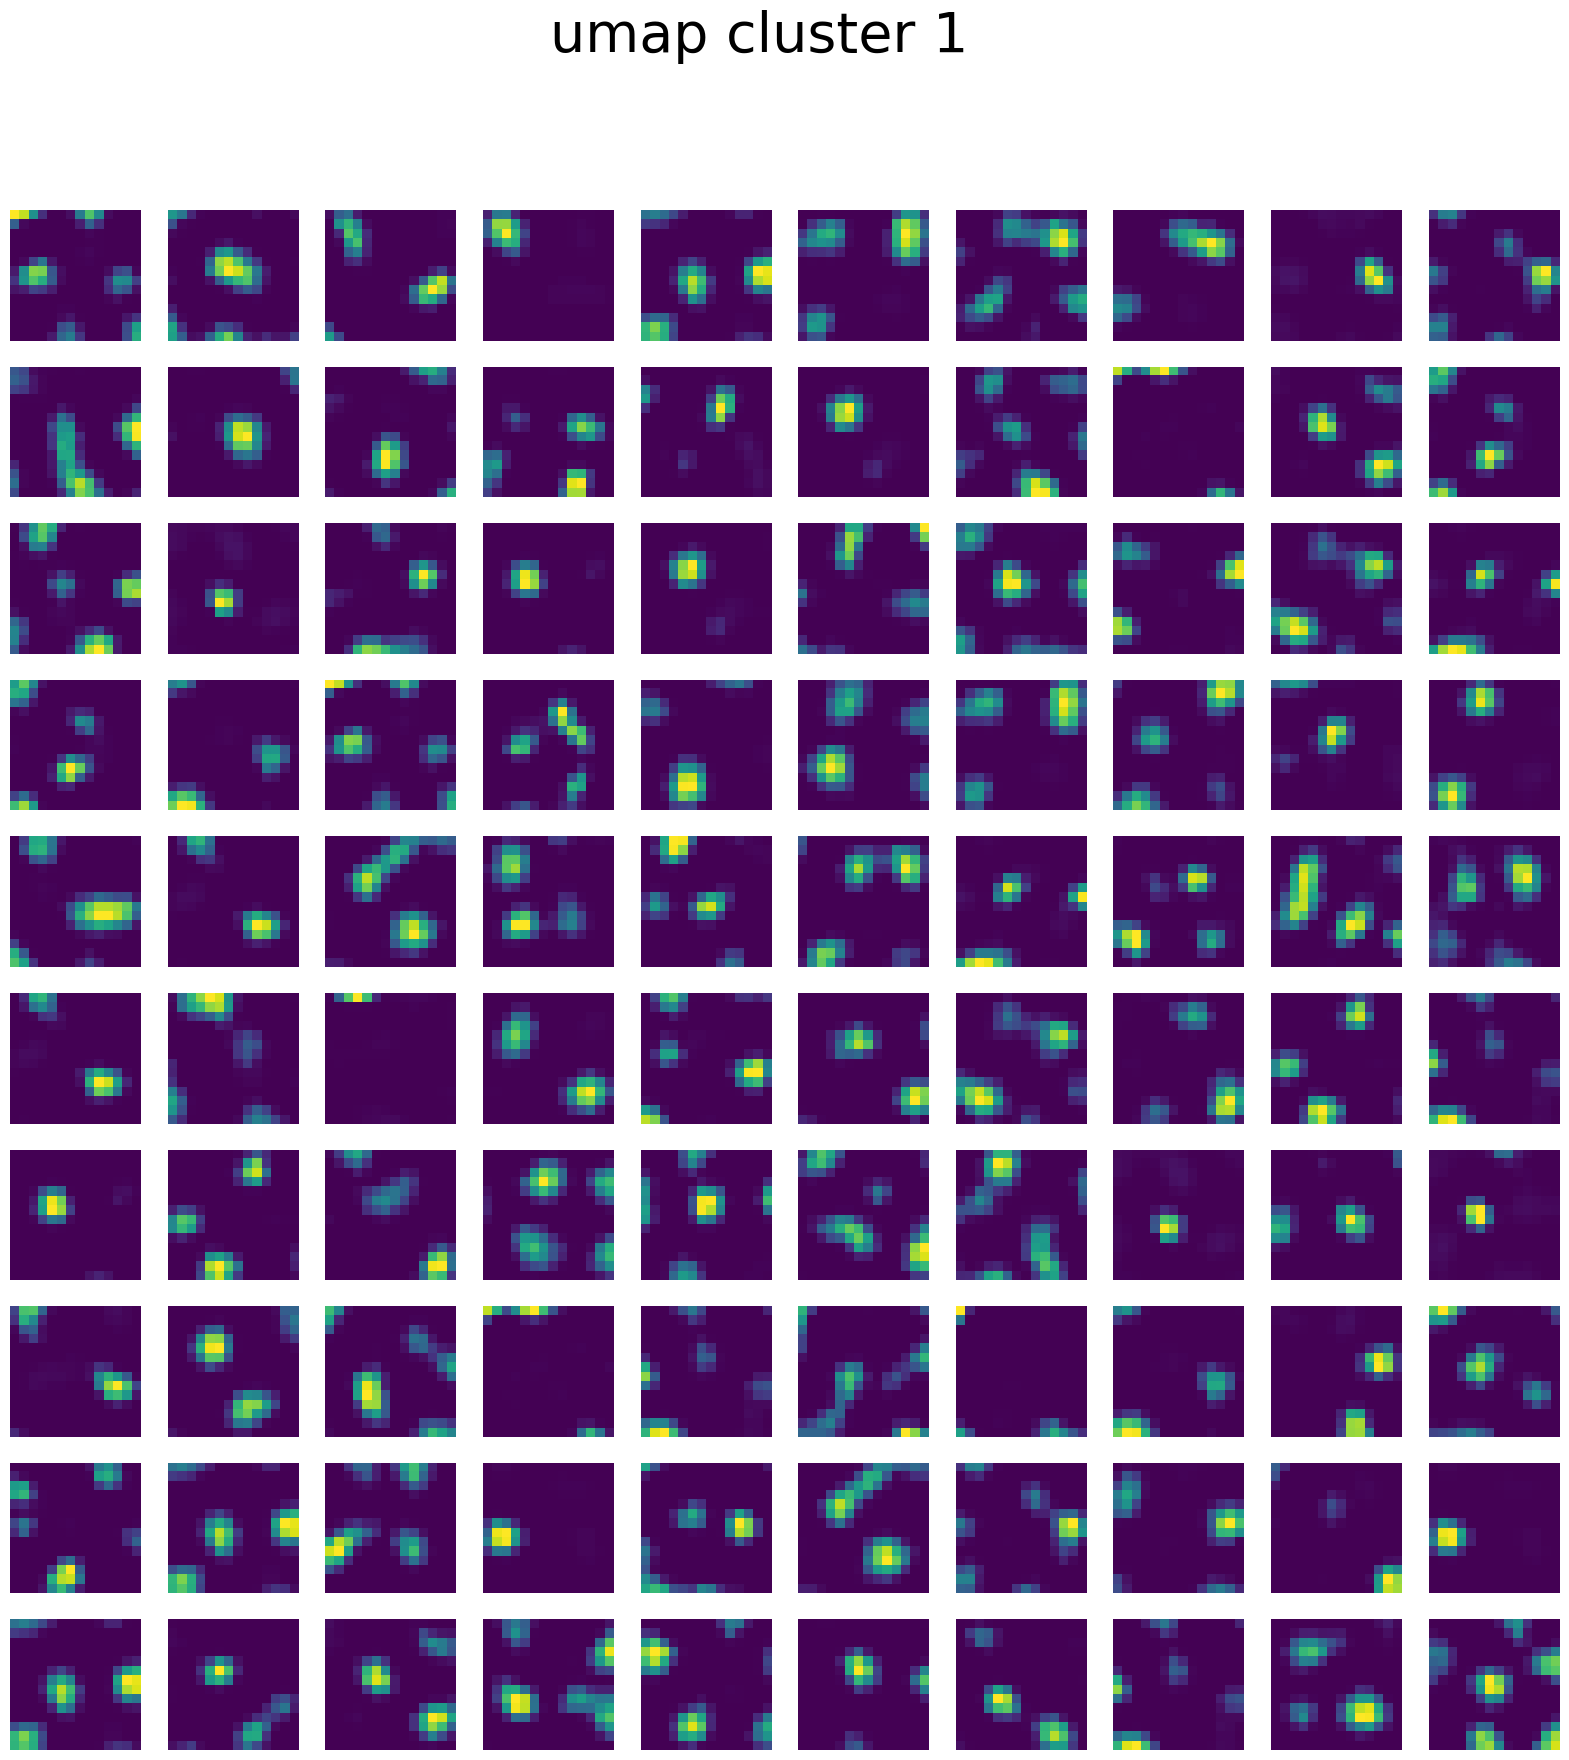

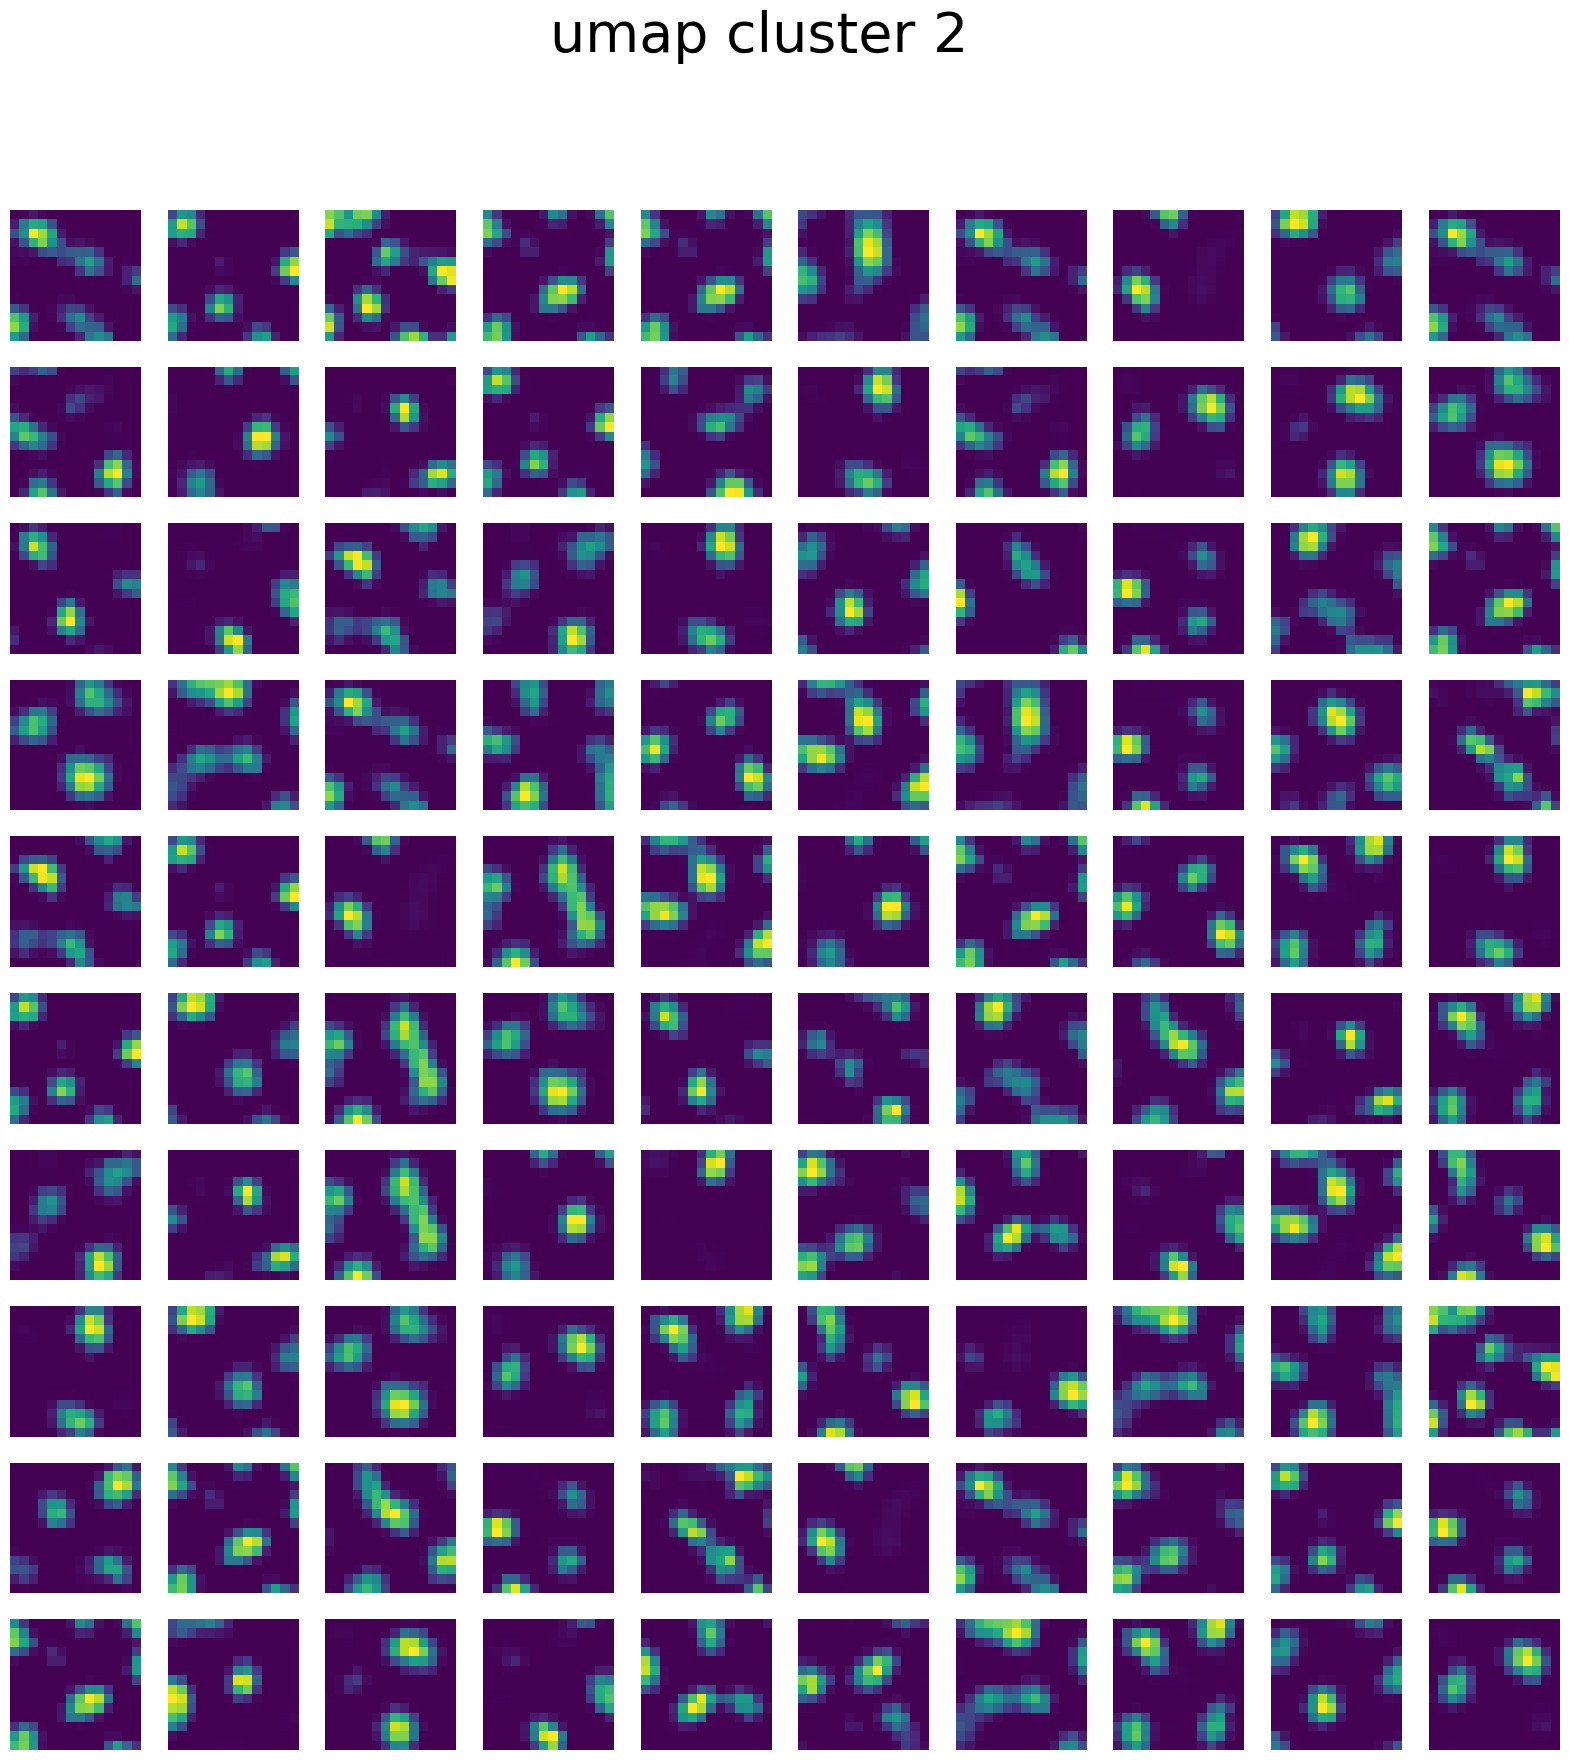

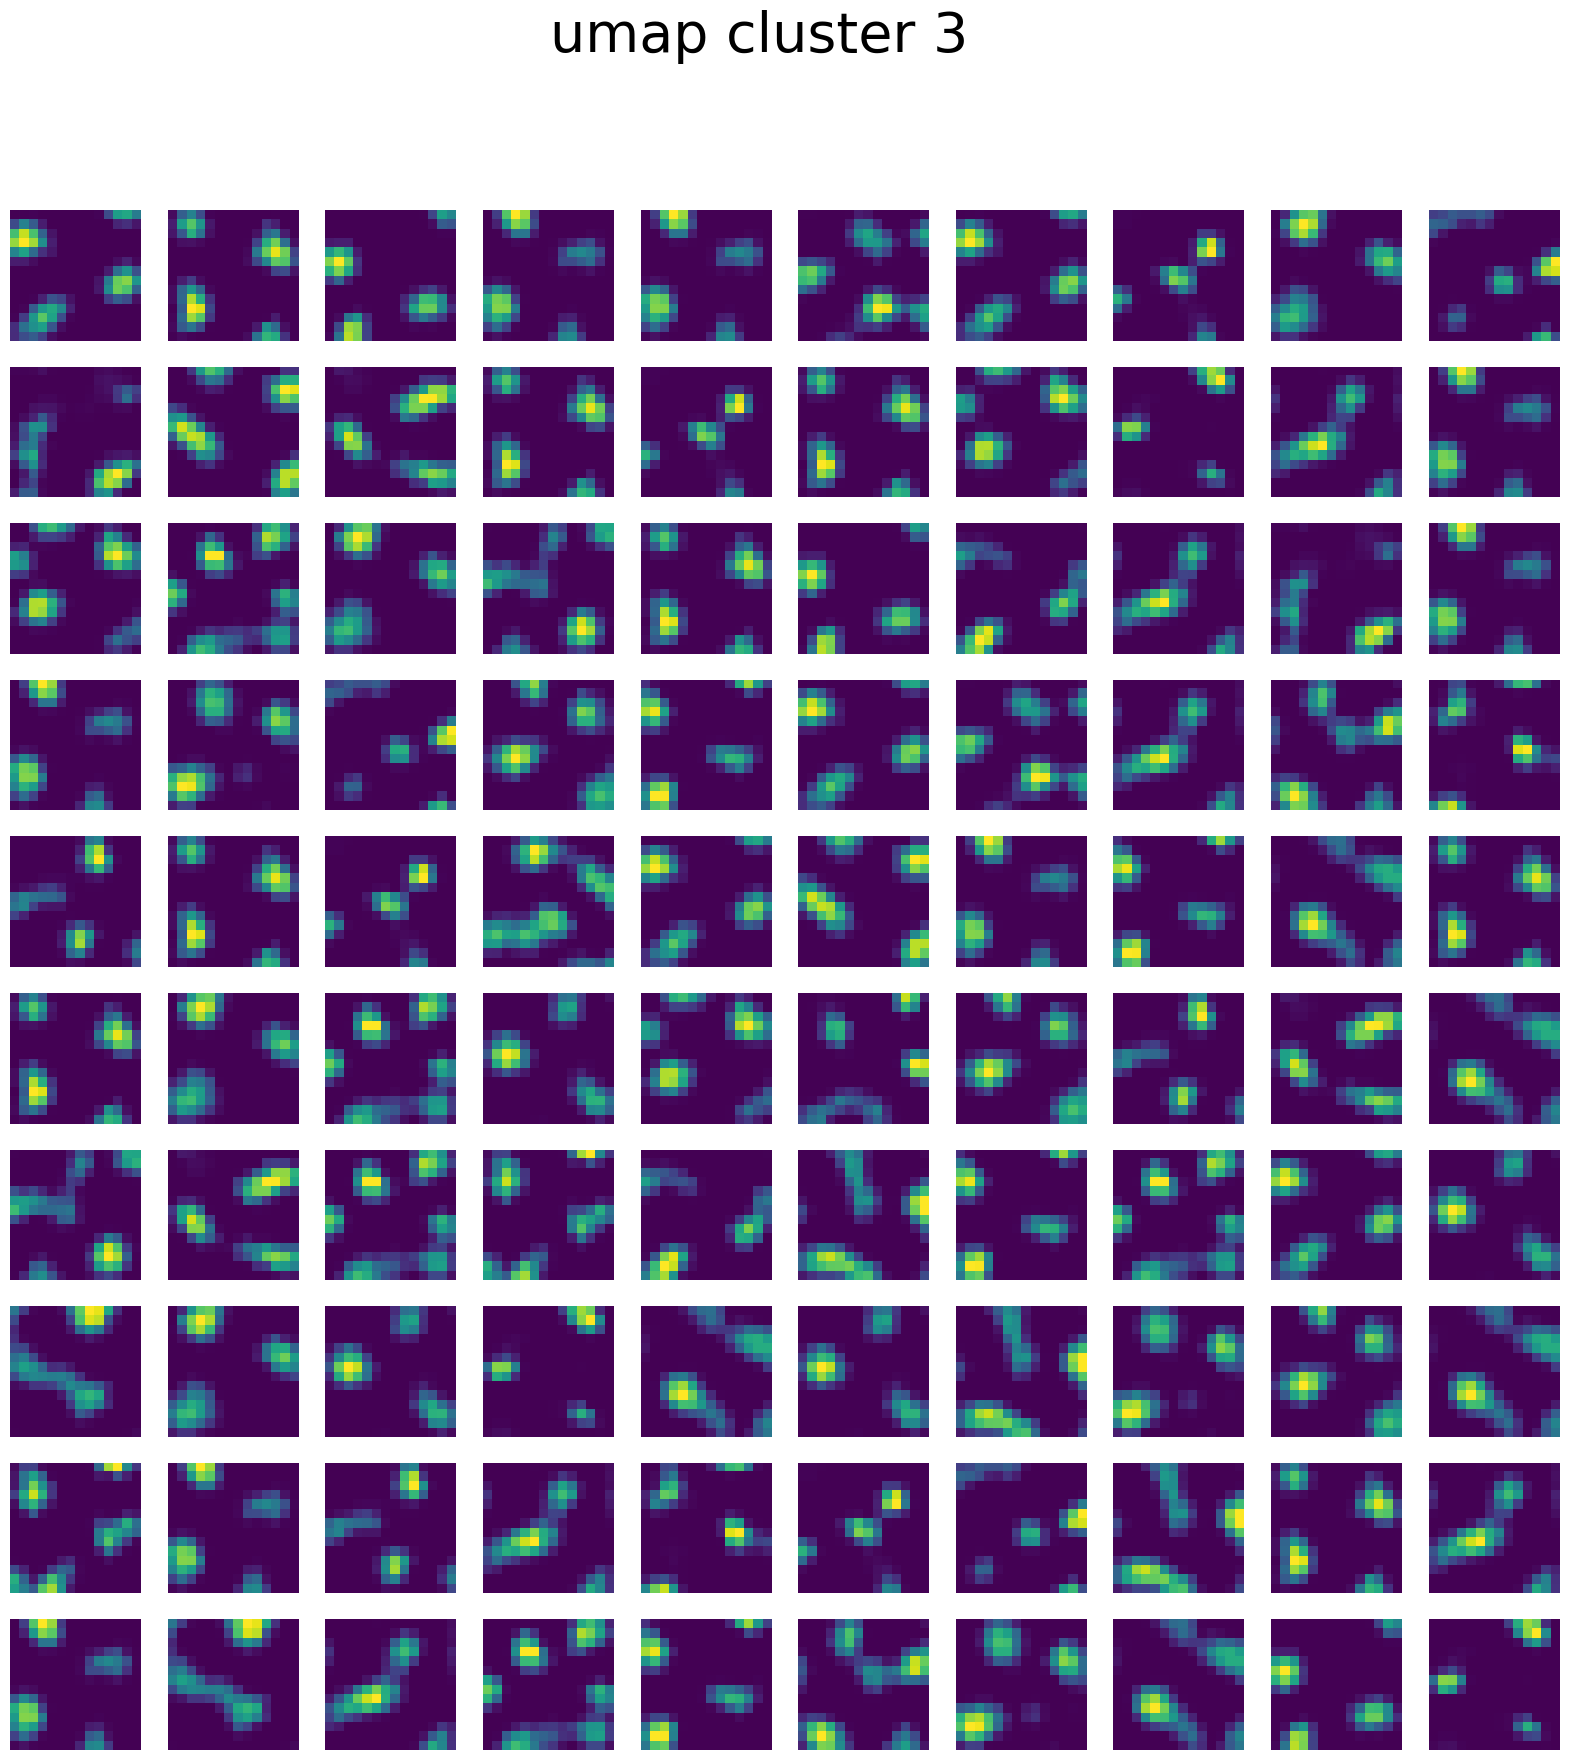

In [19]:
#plotting 100 ratemaps from each cluster!

np.argwhere(labels==2)
for umap_cluster in np.unique(labels):
    unit_indices = np.argwhere(labels==umap_cluster)
    rng = np.random.default_rng(42)  # Use any integer you like
    random_units =  rng.choice(unit_indices,100)
    fig, ax = plt.subplots(10,10, figsize = (20,20))
    fig.suptitle(f'umap cluster {umap_cluster}', fontsize = 40)
    for i, each_unit in enumerate(random_units):
        ax.flatten()[i].imshow(valid_ratemaps[each_unit].squeeze(),origin='lower')
        ax.flatten()[i].axis('off')

## Sorting onto a 2D sheet

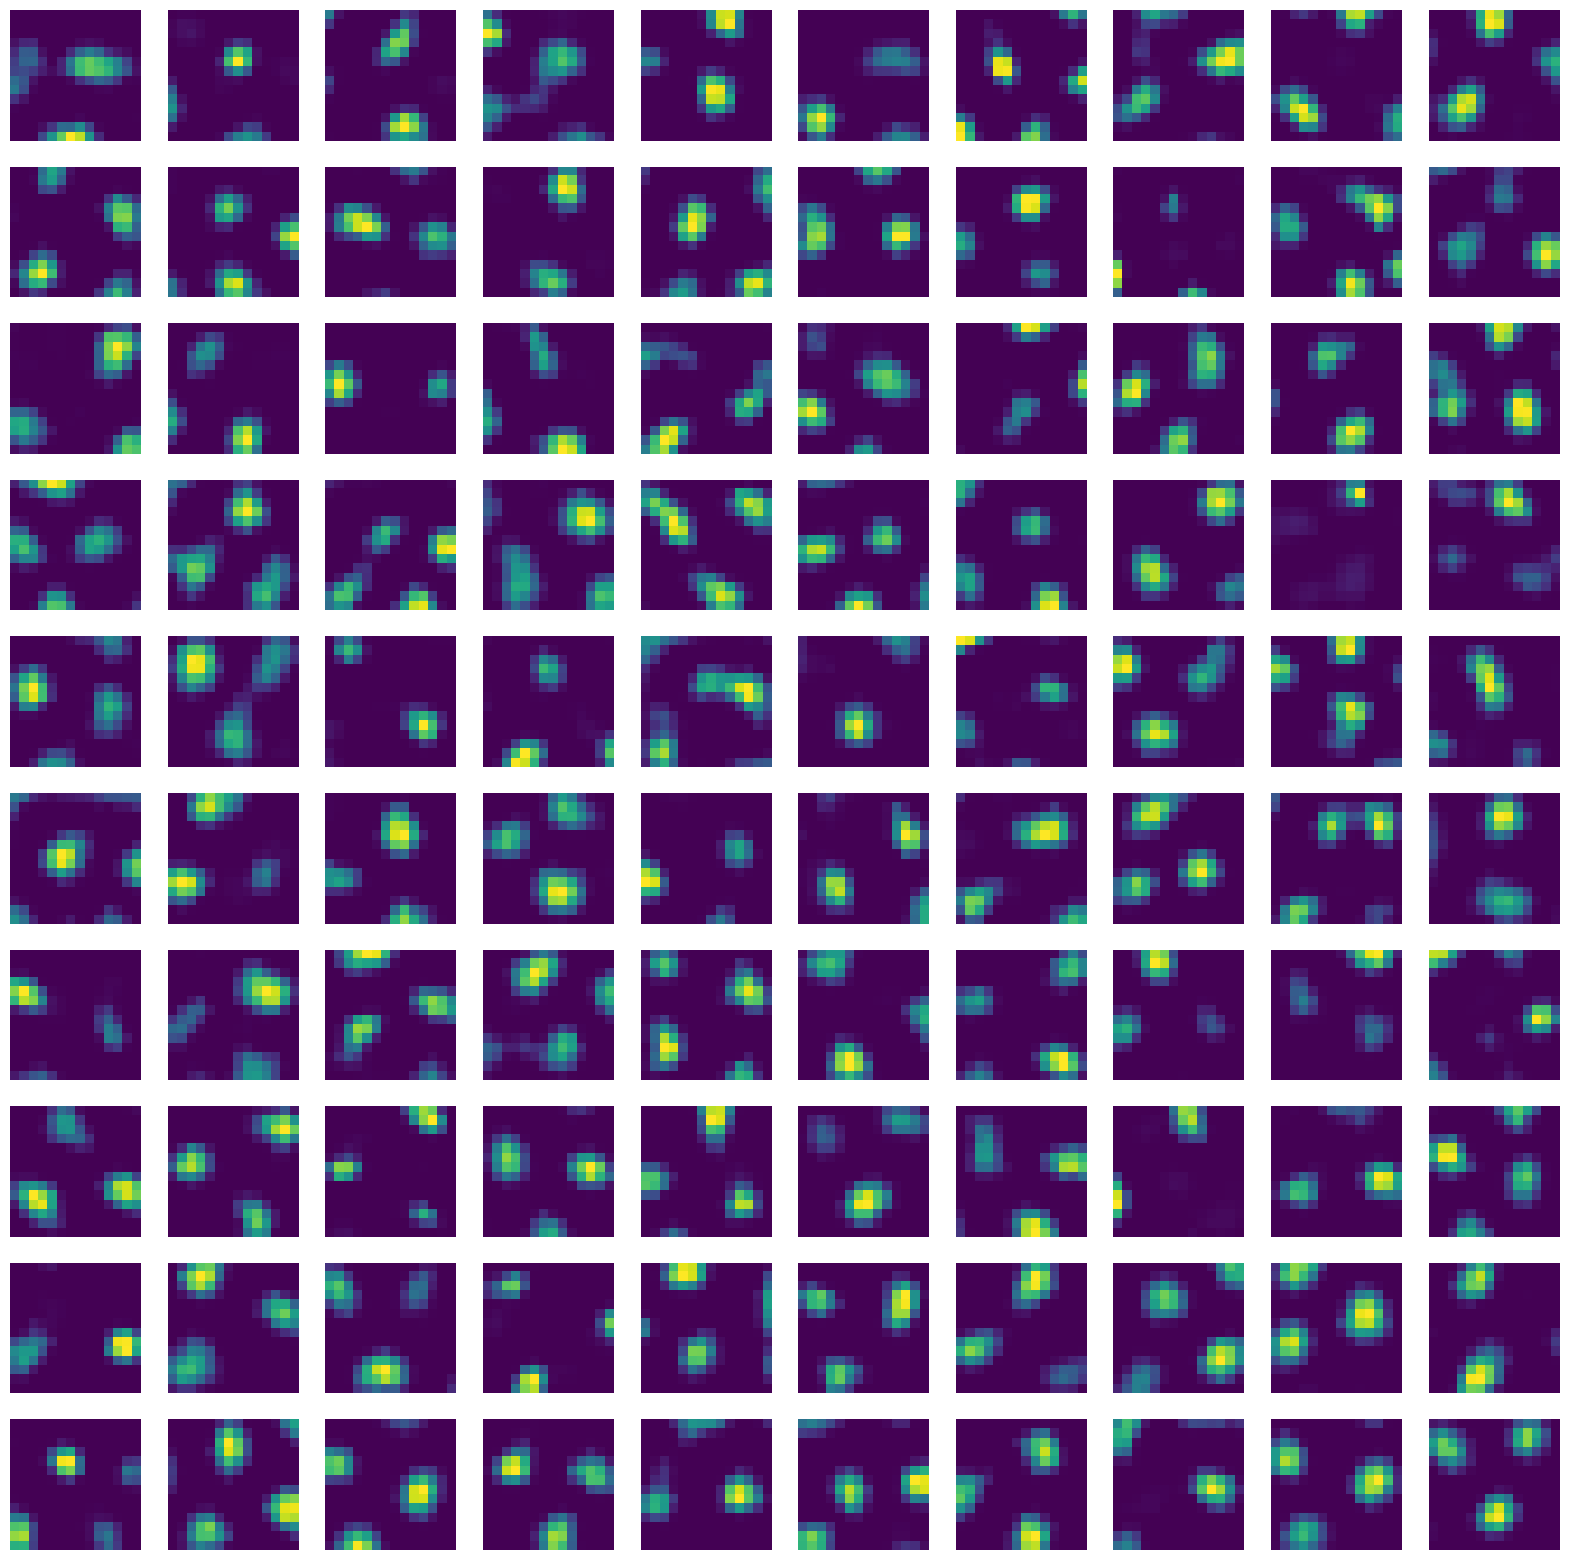

In [20]:
# I actually want to do this based on idealised grid cell fitting and filtering by goodness of fit instead of gridscore.
# sorscher et al. look at top 500 grid scores
sorted_gridscore_idx = np.argsort(grid_scores)

#plot the first 100
plot_indices = sorted_gridscore_idx[-100:]
fig, ax = plt.subplots(10,10, figsize = (20,20))
for i, each_unit in enumerate(plot_indices):
    ax.flatten()[i].imshow(valid_ratemaps[each_unit],origin='lower')
    ax.flatten()[i].axis('off')